In [2]:
import torch.nn as nn
import torch
import numpy as np

Context (c) is the sum of all hidden states multiplied by some Weights $\alpha$ -> Alpha is calculated with a softmax


s is the hidden state of the decoder -> S gets calculated just like a GRU model


 The outpout y_hat is generated using:
 - (decoder) Hidden State, 
 - Last Input (last input will be previous prediction in out case)
 - Context (encoder forward and backward hidden states concatenated)

In [3]:
def init_weights(module: nn.Module):
    """Initializes a single module depending on its type"""
    for param in module.parameters():
        torch.nn.init.xavier_uniform_(param.data)

class Attention_RNN(nn.Module):

    def __init__(self, input_size=1, hidden_size_encoder_h=30, hidden_size_encoder_g=30, decoder_hidden_state_s_length=10, output_size=1):
        super(Attention_RNN, self).__init__()
        self.hidden_size_encoder_h = hidden_size_encoder_h
        self.hidden_size_encoder_g = hidden_size_encoder_g
        
        # Encoder - Bi directional_rnn
        self.encoder_h_Wh = nn.Parameter(torch.FloatTensor(hidden_size_encoder_h, hidden_size_encoder_h))
        self.encoder_h_Wx = nn.Parameter(torch.FloatTensor(hidden_size_encoder_h, input_size))
        self.encoder_h_bias = nn.Parameter(torch.FloatTensor(hidden_size_encoder_h, 1))
        self.encoder_g_Wh = nn.Parameter(torch.FloatTensor(hidden_size_encoder_g, hidden_size_encoder_g))
        self.encoder_g_Wx = nn.Parameter(torch.FloatTensor(hidden_size_encoder_g, input_size))
        self.encoder_g_bias = nn.Parameter(torch.FloatTensor(hidden_size_encoder_g, 1))

        # Decoder
        self.decoder_hidden_s_length = decoder_hidden_state_s_length

        # Decoder - Context Vector Calculation
        self.W_a_s = nn.Parameter(torch.FloatTensor(1, decoder_hidden_state_s_length))
        self.U_a_enc_annot = nn.Parameter(torch.FloatTensor(1, hidden_size_encoder_h + hidden_size_encoder_g))
        self.va_T = nn.Parameter(torch.FloatTensor(1, 1))
        
        # GRU
        self.s_update_gate_Wx = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, input_size))
        self.s_update_gate_Ws = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, decoder_hidden_state_s_length))
        self.s_update_gate_Wc = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, 1))
        
        self.s_reset_gate_Wx = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, input_size))
        self.s_reset_gate_Ws = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, decoder_hidden_state_s_length))
        self.s_reset_gate_Wc = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, 1))

        self.s_Wx = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, input_size)) # weights that are multiplied with input
        self.s_Ws = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, decoder_hidden_state_s_length)) # weights that are multiplied with s_t-1
        self.s_b = nn.Parameter(torch.FloatTensor(decoder_hidden_state_s_length, 1)) # bias for hidden state s

        self.output_Ws = nn.Parameter(torch.FloatTensor(output_size, decoder_hidden_state_s_length))
        self.output_bias = nn.Parameter(torch.FloatTensor(output_size, 1))
        init_weights(self)

    def forward(self, input_sequence: list[float], horizon=20):
        input_sequence = [torch.tensor([[input]], dtype=torch.float32) for input in input_sequence] # map input values to tensors


        # Encoder - BiDir RNN - Forward pass

        # Todo: Forward Passes are GRU!
        forward_hidden_states = torch.tensor([])
        backward_hidden_states = torch.tensor([])

        encoder_h = torch.zeros((self.hidden_size_encoder_h, 1))
        encoder_g = torch.zeros((self.hidden_size_encoder_g, 1))
        for x_t in input_sequence: # compute forward hidden layers
            encoder_h = torch.tanh(torch.mm(self.encoder_h_Wx, x_t) + torch.mm(self.encoder_h_Wh, encoder_h) + self.encoder_h_bias)
            forward_hidden_states = torch.hstack([forward_hidden_states, encoder_h])

        for x_t in reversed(input_sequence): # compute backward hidden layers
            encoder_g = torch.tanh(torch.mm(self.encoder_g_Wx, x_t) + torch.mm(self.encoder_g_Wh, encoder_g) + self.encoder_g_bias)
            backward_hidden_states = torch.hstack([backward_hidden_states, encoder_g])

        encoder_context = torch.vstack([forward_hidden_states, backward_hidden_states])
        
        # Decoder 
        outputs = torch.tensor([])
        s = torch.zeros((self.decoder_hidden_s_length, 1)) # No! Use computation from paper for inital s state: s0 = tanh (Wsh1 ,whereWs∈R) .
        
        for i in range(horizon):
            if i == 0:
                x_t = input_sequence[-1] # for t=1 take last element of sequence as input, 
            else:
                x_t = torch.tensor([[outputs[0][-1]]]) # after first run we will use the output of t as input for t+1
            scores = torch.tensor([])
            
            for column_idx in range(encoder_context.shape[1]):
                encoder_column = encoder_context[:,column_idx].view(self.hidden_size_encoder_g + self.hidden_size_encoder_h, 1)
                test_s = torch.tanh(torch.mm(self.W_a_s, s))
                test_h = torch.tanh(torch.mm(self.U_a_enc_annot, encoder_column))
                enc = self.va_T * (test_s + test_h)
                scores = torch.hstack((scores, enc))
            scores = scores.view(-1) # reduce dimensionality to an array of length of input_sequence

            alpha = torch.exp(scores) / torch.sum(torch.exp(scores)) # compute soft alignment via softmax

            context_vector = alpha * torch.sum(encoder_context, dim=0) # column wise sum of encoder hidden states, elementwise multiplied with the soft aligment (alpha)

            update_gate = torch.sigmoid(torch.mm(self.s_update_gate_Wx, x_t) + torch.mm(self.s_reset_gate_Ws, s) + !! TODO!!)
            reset_gate = torch.sigmoid(torch.mm(self.s_reset_gate_Wx, x_t) + torch.mm(self.s_reset_gate_Ws, s) + !! TODO -- torch.mm(self.s_reset_gate_Wc, context_vector)) # how do i include the context vector here?

            s_hat = torch.tanh(torch.mm(self.s_Wx, x_t) + torch.mm(self.s_Ws, reset_gate * s) + self.s_b)
            s = (1 - update_gate) * s + update_gate * s_hat

            output = torch.mm(self.output_Ws, s) + self.output_bias
            outputs = torch.hstack([outputs, output])

        # TODO:
        # - Context Vector einbauen!
        
        return outputs
rnn = Attention_RNN()
res = rnn.forward([1,2,3])

SyntaxError: invalid syntax (177682063.py, line 91)

In [ ]:
import numpy as np

# Given information
T_x = 5  # Length of input sequence
h_j = np.random.randn(T_x, 20)  # Example annotations
s_i_minus_1 = np.random.randn(20)  # Example previous hidden state

# Step 1: Compute Alignment Scores
e_ij = np.dot(h_j, s_i_minus_1)  # Example, you might use your alignment model here

# Step 2: Convert Scores to Probabilities (Softmax)
alpha_ij = np.exp(e_ij) / np.sum(np.exp(e_ij))

# Step 3: Compute Context Vector
c_i = np.dot(alpha_ij, h_j)

# c_i is now the context vector for the current target word
print(c_i)


[ 1.90601495  1.63867351 -1.47113026  1.33913807 -0.0960888  -1.86554678
 -1.15236933 -0.32852723  1.53189361  2.01740418 -1.47527157 -0.91008446
 -0.33660687  1.53313289  0.65655206 -0.02461345  0.61042546  0.10423771
 -1.94875334  0.55574617]


The alignment model makes every column (every encoder hidden state) to 1 scalar value.
So we need to do a another linear transformation - we should have an array of values with the length of the sequence.

Then we have eg 5 values and compute the softmax for each value

In [ ]:
h_j

array([[ 1.39122158, -0.35900938, -0.02724631,  0.99284855, -0.54483422,
        -0.4454687 ,  1.05830879,  0.18275135, -0.57850272, -1.30729521,
        -1.40520216, -0.62124035,  0.06086983, -0.76725387,  0.65492017,
        -0.97496826, -1.46493554,  2.0951481 , -2.06958731,  1.63479271],
       [-0.24591995, -1.03656163, -1.23235428, -1.65390963, -0.70743348,
        -1.22892547,  0.16049599,  1.25423442, -0.04845718, -1.63890873,
         0.39184552,  0.9025752 ,  0.72913689, -0.7562229 , -0.2987512 ,
        -0.03213972, -0.01735861,  0.45435268, -0.60665298, -0.81922412],
       [ 1.90647258,  1.64018429, -1.47225074,  1.33943024, -0.09575999,
        -1.86665818, -1.15402338, -0.32892218,  1.53350443,  2.01991328,
        -1.47535611, -0.91032865, -0.33689583,  1.53485998,  0.65655237,
        -0.02390761,  0.61196465,  0.10276552, -1.94869079,  0.55495783],
       [-1.30503722, -1.21921882,  0.57068719, -0.80024686,  0.43679601,
        -0.20774427, -0.88725707, -0.014516  , -

In [ ]:
import numpy as np

# Example dimensions
T_x = 4  # Length of the input sequence
d_h = 2  # Dimensionality of annotation vectors and context vector

# Example values (randomly generated for illustration)
alpha_ij = np.array([0.2, 0.1, 0.5, 0.2])  # Attention weights
h_j = np.random.randn(T_x, d_h)  # Annotation vectors

# Calculate context vector
c_i = np.dot(alpha_ij, h_j)

# Display the results
print("Attention Weights (alpha_ij):", alpha_ij)
print("\nAnnotation Vectors (h_j):")
print(h_j)
print("\nContext Vector (c_i):", c_i)


Attention Weights (alpha_ij): [0.2 0.1 0.5 0.2]

Annotation Vectors (h_j):
[[ 0.26796207  2.14448422]
 [ 1.50859956  0.80246791]
 [ 0.36710484 -1.38135004]
 [ 0.13026343 -0.14947087]]

Context Vector (c_i): [ 0.41405748 -0.21142556]


TrainingStats(train_loss=[0.39733496, 0.24637589, 0.24117321, 0.20901583, 0.16955718, 0.14991644, 0.1403915, 0.13722473, 0.13666837, 0.13357273, 0.13315228, 0.13135038, 0.12950404, 0.12838815, 0.12688854, 0.12395009, 0.12386604, 0.1238686, 0.12171662, 0.11977352, 0.118570134, 0.117398664, 0.116591275, 0.11607702, 0.11437524, 0.112636484, 0.10804546, 0.09998703, 0.091326736, 0.08132275, 0.073036246, 0.06644494, 0.061889548, 0.05733663, 0.054021772, 0.05088147, 0.04715996, 0.048001904, 0.04553396, 0.043848958, 0.043642737, 0.041180167, 0.04007263, 0.039912727, 0.03833393, 0.03758995, 0.03911686, 0.03667086, 0.0370873, 0.037420716, 0.035166364, 0.036606327, 0.034548774, 0.03476655, 0.03517826, 0.033606835, 0.03501975, 0.033763055, 0.03424889, 0.034543682, 0.032058638, 0.031712234, 0.032339945, 0.032349244, 0.030986246, 0.031099064, 0.030327018, 0.03068872, 0.030410172, 0.031653028, 0.03011746, 0.030334385, 0.02907553, 0.031283002, 0.02852832, 0.029812686, 0.029324241, 0.029096132, 0.02874

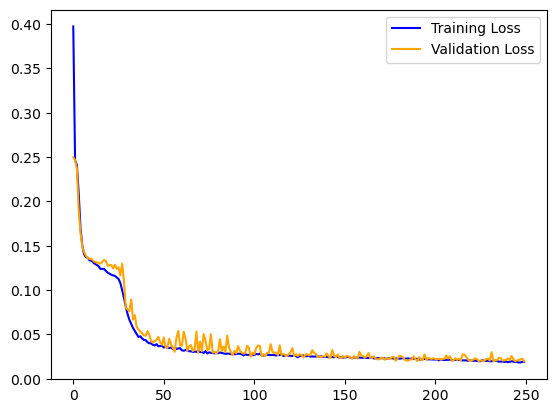

In [1]:
from models import Base_RNN, GRU_RNN
import torch
import torch.nn as nn
from pipeline import train, evaluate
from sklearn.model_selection import train_test_split
from data_generation import generate_longterm_data

NUM_SEQ = 1000
HORIZON=20
data_set, labels = generate_longterm_data(NUM_SEQ, variable_steps=False, noise=True, horizon=HORIZON)

X_train, X_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.2, random_state=42)

gru_model = GRU_RNN(1,30,1)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
adam = torch.optim.Adam(gru_model.parameters(), lr=3e-4)
EPOCHS = 250


adam_gru = torch.optim.Adam(gru_model.parameters(), lr=3e-4)

train(gru_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam_gru)

(0.00055187894, 0.00030632212)

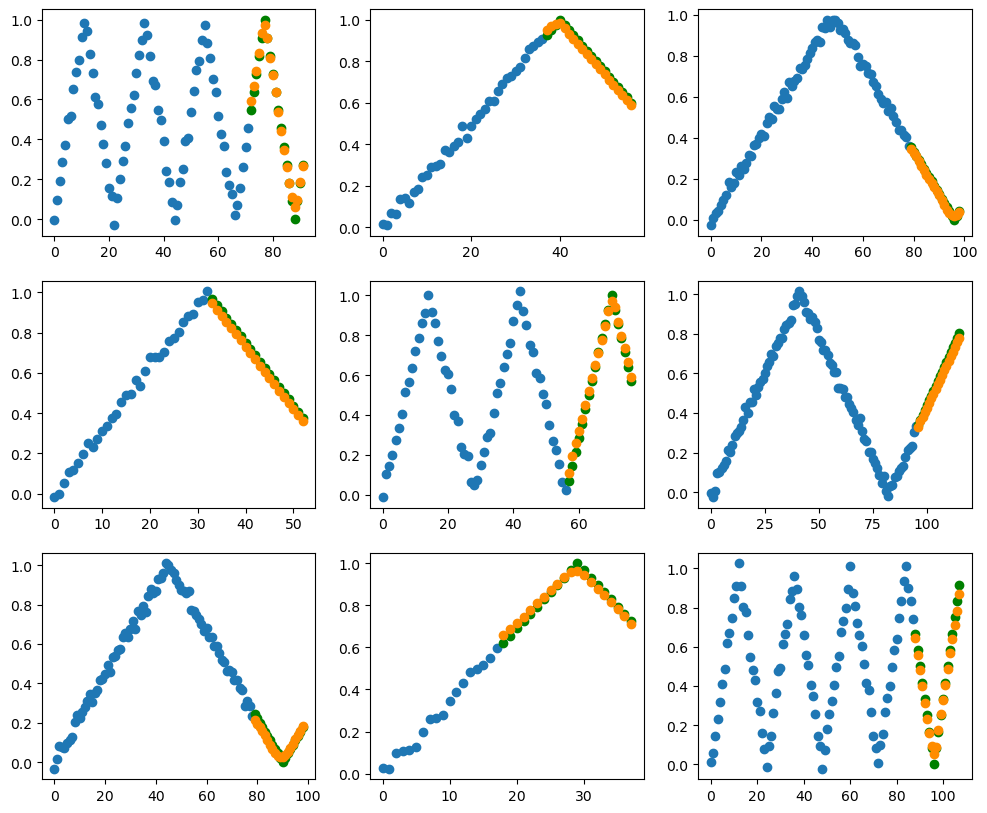

In [5]:
evaluate(gru_model, X_test, y_test, visualize_start_idx=18)